In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from typing import List
from MRL import FixedFeatureLayer, Matryoshka_CE_Loss, MRL_Linear_Layer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 20
learning_rate = 1e-3

In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [4]:
class BasicAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 36), nn.ReLU(),
            nn.Linear(36, 18), nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18), nn.ReLU(),
            nn.Linear(18, 36), nn.ReLU(),
            nn.Linear(36, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class MRL_Autoencoder(nn.Module):
    def __init__(self, nesting_list: List[int], num_classes: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, nesting_list[-1])
        )
        self.decoder = nn.Sequential(
            nn.Linear(nesting_list[-1], 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 784), nn.Sigmoid()
        )
        self.classifier = MRL_Linear_Layer(nesting_list, num_classes)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), self.classifier(z)

In [ ]:
def train_models():
    basic_model = BasicAutoencoder().to(device)
    mrl_model = MRL_Autoencoder([9, 18, 36], num_classes=10).to(device)

    optimizer_basic = optim.Adam(basic_model.parameters(), lr=learning_rate)
    optimizer_mrl = optim.Adam(mrl_model.parameters(), lr=learning_rate)
    
    recon_loss_fn = nn.MSELoss()
    clf_loss_fn = Matryoshka_CE_Loss(relative_importance=[0.2, 0.3, 0.5])

    basic_losses, mrl_losses = [], []

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(-1, 784).to(device)
            labels = labels.to(device)

            # === Basic AE ===
            basic_out = basic_model(images)
            basic_loss = recon_loss_fn(basic_out, images)

            optimizer_basic.zero_grad()
            basic_loss.backward()
            optimizer_basic.step()
            basic_losses.append(basic_loss.item())

            # === MRL AE ===
            recon, logits = mrl_model(images)
            recon_loss = recon_loss_fn(recon, images)
            clf_loss = clf_loss_fn(logits, labels)
            mrl_loss = recon_loss + clf_loss

            optimizer_mrl.zero_grad()
            mrl_loss.backward()
            optimizer_mrl.step()
            mrl_losses.append(mrl_loss.item())

        print(f"Epoch {epoch+1}/{epochs} | Basic Loss: {basic_loss.item():.4f} | MRL Loss: {mrl_loss.item():.4f}")

    return basic_model, mrl_model, basic_losses, mrl_losses

In [6]:
def plot_losses(basic_losses, mrl_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(basic_losses, label="Basic AE Loss")
    plt.plot(mrl_losses, label="MRL AE Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Autoencoder vs MRL-Autoencoder")
    plt.grid(True)
    plt.show()

Epoch 1/20 | Basic Loss: 0.0403 | MRL Loss: 0.3615
Epoch 2/20 | Basic Loss: 0.0275 | MRL Loss: 0.1516
Epoch 3/20 | Basic Loss: 0.0296 | MRL Loss: 0.1384
Epoch 4/20 | Basic Loss: 0.0234 | MRL Loss: 0.0232
Epoch 5/20 | Basic Loss: 0.0272 | MRL Loss: 0.0290
Epoch 6/20 | Basic Loss: 0.0261 | MRL Loss: 0.0725
Epoch 7/20 | Basic Loss: 0.0279 | MRL Loss: 0.0666
Epoch 8/20 | Basic Loss: 0.0301 | MRL Loss: 0.0647
Epoch 9/20 | Basic Loss: 0.0262 | MRL Loss: 0.0373
Epoch 10/20 | Basic Loss: 0.0222 | MRL Loss: 0.0216
Epoch 11/20 | Basic Loss: 0.0191 | MRL Loss: 0.0450
Epoch 12/20 | Basic Loss: 0.0215 | MRL Loss: 0.0214
Epoch 13/20 | Basic Loss: 0.0188 | MRL Loss: 0.0588
Epoch 14/20 | Basic Loss: 0.0216 | MRL Loss: 0.0214
Epoch 15/20 | Basic Loss: 0.0242 | MRL Loss: 0.0236
Epoch 16/20 | Basic Loss: 0.0156 | MRL Loss: 0.0161
Epoch 17/20 | Basic Loss: 0.0145 | MRL Loss: 0.0163
Epoch 18/20 | Basic Loss: 0.0201 | MRL Loss: 0.0186
Epoch 19/20 | Basic Loss: 0.0212 | MRL Loss: 0.0178
Epoch 20/20 | Basic L

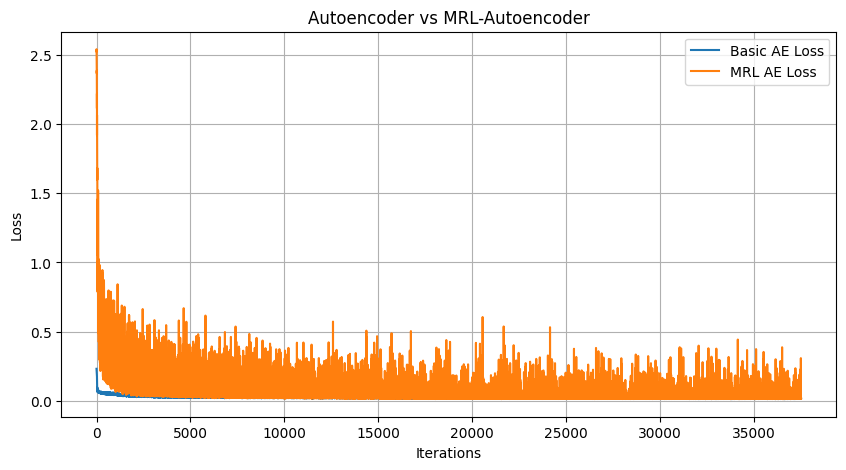

Models saved.


In [8]:
basic_model, mrl_model, basic_losses, mrl_losses = train_models()
plot_losses(basic_losses, mrl_losses)
torch.save(basic_model.state_dict(), "../output/basic_autoencoder_comp.pth")
torch.save(mrl_model.state_dict(), "../output/mrl_autoencoder_comp.pth")
print("Models saved.")